In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [3]:
%matplotlib inline

from sessions import selected_008229, selected_013608
from imports import *
from scipy import stats
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from correlation import cluster_corr
#from skimage.color import rgba2rgb
import matplotlib.animation as animation

#import cv2
#from sklearn import decomposition

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [6]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
#source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
source = '/Users/andrey/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/PPC/video'

selected = selected_013608
selected

['013608_ppcSIT_2025-01-06_13-20-52',
 '013608_ppcSIT_2025-01-07_08-47-27',
 '013608_ppcSIT_2025-01-07_15-38-23',
 '013608_ppcSIT_2025-01-09_09-09-55',
 '013608_ppcSIT_2025-01-10_09-25-04',
 '013608_ppcSIT_2025-01-13_14-01-40',
 '013608_ppcSIT_2025-01-14_10-20-14',
 '013608_ppcSIT_2025-01-15_14-56-18',
 '013608_ppcSIT_2025-01-16_09-49-21',
 '013608_ppcSIT_2025-01-17_10-07-00',
 '013608_ppcSIT_2025-01-20_09-38-20',
 '013608_ppcSIT_2025-01-21_08-50-02',
 '013608_ppcSIT_2025-01-22_12-59-00',
 '013608_ppcSIT_2025-01-23_08-46-51',
 '013608_ppcSIT_2025-01-24_08-19-45',
 '013608_ppcSIT_2025-01-27_09-00-20']

In [13]:
#session = selected[2]
session = '013608_ppcSIT_2025-01-22_12-59-00'
session

'013608_ppcSIT_2025-01-22_12-59-00'

In [495]:
s1 = "008229_hippoSIT_2022-05-16_20-36-44"
units_all = {  # take 0.5 time step
    1: [7, 8, 10, 23, 24, 33, 36, 37, 38],
    2: [9, 15],
    5: [13],
    6: [5, 10, 18, 23, 25, 26],
    7: [2, 3, 4, 5, 6, 7, 9, 12, 14, 15, 17, 18],
    8: [3, 5, 6, 9, 12, 13, 14, 15, 16, 17, 18, 19],
}

s2 = "008229_hippoSIT_2022-05-17_21-44-43"
units_all = {
    1: [2, 4, 8, 15, 19, 26, 28],
    3: [3, 8, 12, 13, 14],
    4: [2, 4, 8, 16],
    5: [7, 15, 16, 18, 20, 25, 28, 29, 31],
    6: [2, 4, 5, 7, 18, 19, 20, 21],
    7: [8, 13, 14, 15, 16, 17, 18, 19],
    8: [2, 4, 5, 8, 10, 11, 12, 13, 15, 16, 17],
}

s3 = '008229_hippoSIT_2022-05-18_14-36-18'
units_all = {
    1: [2, 4, 17, 18, 20, 24, 26],  # 16, 21 food
    3: [2, 6, 7, 8],
    4: [10, 13, 14, 15, 16, 17, 18, 19, 20, 21],
    5: [21, 22, 24, 25, 26, 27],
    6: [2, 14, 15, 16, 17, 18, 19, 20],
    7: [3, 5, 6, 8, 9, 10, 15, 16],  # could be spatial / ego
    8: [2, 3, 4, 5, 6, 8, 12, 16, 17, 18],
}

# s4 = "008229_hippoSIT_2022-05-20_15-54-39"
# units_all = {
#     1: [10, 13, 15],
#     2: [4, 6, 8, 9, 10, 11],
#     3: [3, 5, 8, 11, 13, 14, 15, 17, 18, 19, 20, 21],
#     4: [3, 5, 8, 12, 13, 14],
#     5: [5, 6],
#     6: [3, 5, 7, 8, 9, 11, 14],  # 7, 11 - food
#     7: [2, 3, 4, 7, 8, 9],
#     8: [3, 7, 11, 12],
# }

In [496]:
unit_names = []
for el, units in units_all.items():
    for u in units:
        unit_names.append('%s-%s' % (el, u))
unit_names[:5], len(unit_names)

(['1-2', '1-4', '1-17', '1-18', '1-20'], 53)

## Load units

In [14]:
animal = session.split('_')[0]

s_path     = os.path.join(source, animal, session)
meta_file  = os.path.join(s_path, 'meta.h5')
unit_file  = os.path.join(s_path, 'units.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    events = np.array(f['processed']['sound_events'])
    trials = np.array(f['processed']['trial_idxs'])

In [15]:
single_units, spike_times = {}, {}
with h5py.File(unit_file, 'r') as f:
    unit_names = [x for x in f]
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])

### Hierarchical clustering

In [498]:
# build correlation matrices

# l = len(unit_names)
# corr_pearson, corr_spearman = np.zeros((l, l)), np.zeros((l, l))
# for i, u1 in enumerate(unit_names):
#     for j, u2 in enumerate(unit_names):
#         i_rate1 = single_units[u1]
#         i_rate2 = single_units[u2]

#         corr_pearson[i, j]  = stats.pearsonr(i_rate1, i_rate2)[0]
#         #corr_spearman[i, j] = stats.spearmanr(i_rate1, i_rate2)[0]

In [20]:
len(single_units)

120

In [16]:
unit_mx = np.array([single_units[u] for u in unit_names])

cov_mx = np.cov(unit_mx)

cov_mx[cov_mx > 20] = 20
cov_mx[cov_mx < -20] = -20

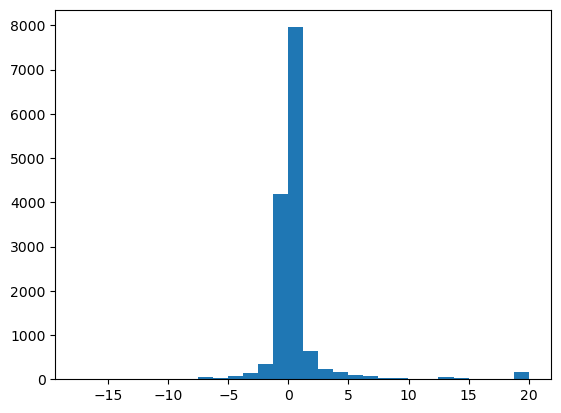

In [21]:
_ = plt.hist(cov_mx.flatten(), bins=30)
plt.show()

In [22]:
plt.imshow(cov_mx)

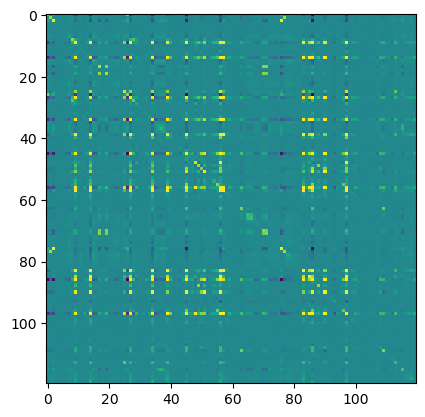

In [23]:
plt.show()

In [24]:
#corr_srt, Z, labels, idxs_sort = cluster_corr(corr_pearson, threshold=2.6)
corr_srt, Z, labels, idxs_sort = cluster_corr(cov_mx, threshold=50.)
labels_dict = dict([(u, l) for u, l in zip(unit_names, labels)])

In [25]:
units_sorted = [unit_names[i] for i in idxs_sort]

In [26]:
tick_labels = ["(%s) %s" % (labels_dict[u], u) for u in units_sorted]

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
ax.imshow(corr_srt, cmap='seismic')
ax.set_xticks(range(corr_srt.shape[0]))
ax.set_xticklabels(tick_labels, rotation=60)
ax.set_yticks(range(corr_srt.shape[0]))
_ = ax.set_yticklabels(tick_labels, fontsize=7)
for clu_no in set(labels):
    l_pos = np.where(labels[idxs_sort] == clu_no)[0][-1] + 0.5
    ax.axhline(l_pos, color='black', lw=3)
    ax.axvline(l_pos, color='black', lw=3)

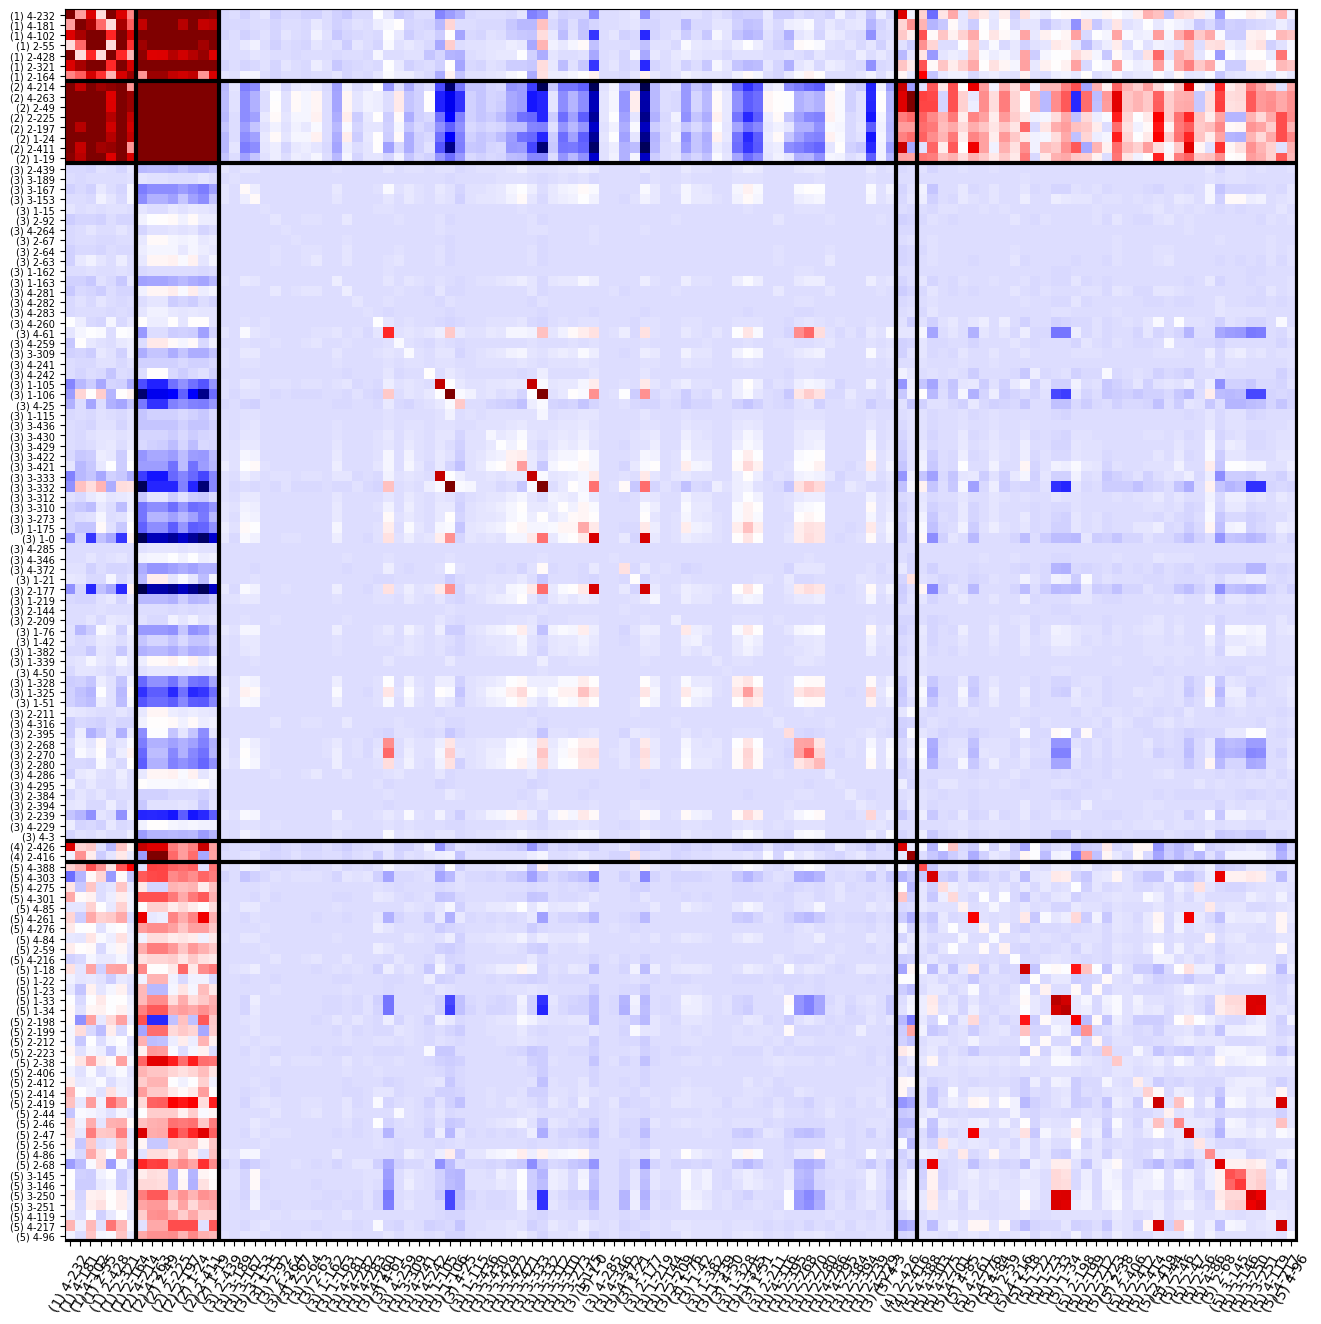

In [27]:
plt.show()

In [335]:
# save to json 
to_save = [
    [unit_names[j] for j in idxs_sort],
    [int(labels[j]) for j in idxs_sort]
]

jf_name = os.path.join(rep_path, '%s_units_sorted.json' % session[-19:-6])
with open(jf_name, 'w') as f:
    f.write(json.dumps(to_save))

In [247]:
with open(jf_name, 'r') as f:
    units_data  = json.load(f)
    unit_names  = units_data[0]
    unit_labels = units_data[1]

## Use PCA to sort units

In [182]:
from sklearn import decomposition

pca_unit_mx = decomposition.PCA(n_components=20)
pca_unit_mx.fit(cov_mx)
X = pca_unit_mx.transform(cov_mx)

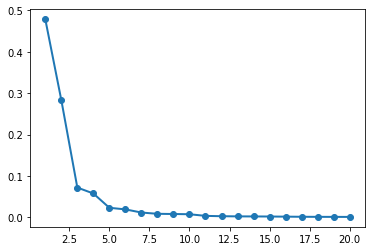

In [184]:
# scree plot
PC_values = np.arange(pca_unit_mx.n_components_) + 1
plt.plot(PC_values, pca_unit_mx.explained_variance_ratio_, 'o-', linewidth=2)

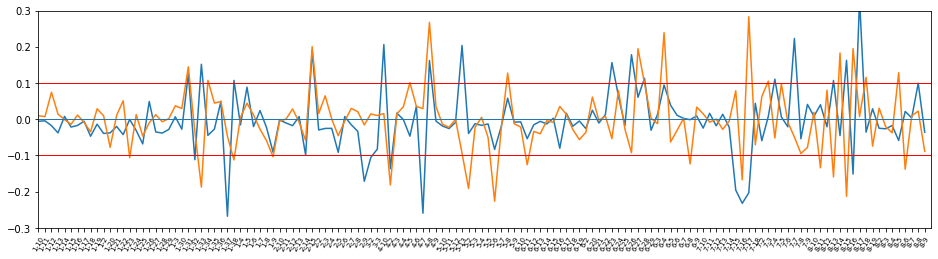

In [205]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

ax.plot(pca_unit_mx.components_[0])
ax.plot(pca_unit_mx.components_[1])
ax.set_xticks(range(len(unit_names)))
ax.set_xticklabels(unit_names, rotation=60, fontsize=7)
ax.set_xlim(0, len(unit_names))
ax.set_ylim(-0.3, 0.3)
ax.axhline(0, lw=1)
ax.axhline( 0.1, lw=1, color='red')
ax.axhline(-0.1, lw=1, color='red')

In [203]:
[unit_names[i] for i in np.where(pca_unit_mx.components_[0] > 0.1)[0]]

['1-31',
 '1-33',
 '1-38',
 '2-15',
 '4-10',
 '4-8',
 '5-13',
 '6-23',
 '6-26',
 '6-28',
 '7-4',
 '7-7',
 '8-13',
 '8-15',
 '8-17']

In [204]:
[unit_names[i] for i in np.where(pca_unit_mx.components_[0] < -0.1)[0]]

['1-32', '1-37', '2-9', '3-2', '4-2', '4-7', '7-15', '7-16', '7-17', '8-16']

### Plot fire matrix

In [28]:
do_animate = False

In [29]:
# timeline indices
idxs_target = np.where(tl[:, 6] == 2)[0]
idxs_backgr = np.where(tl[:, 6] == 1)[0]
idxs_noise  = np.where(tl[:, 6] ==-1)[0]
#idxs_reward = trials[trials[:, 5] == 1][:, 1].astype(np.int32)  # another way
idxs_reward = tgt_mx[tgt_mx[:, 4] == 1][:, 3]

# events
idxs_to_idx = np.where(np.diff(idxs_backgr) > 5)[0] + 1
idxs_bgr_start = idxs_backgr[:-1][idxs_to_idx]
idxs_to_idx = np.where(np.diff(idxs_noise) > 5)[0] + 1
idxs_nos_start = np.concatenate([[idxs_noise[0]], idxs_noise[:-1][idxs_to_idx]])
idxs_tgt_start = tgt_mx[:, 2]

In [30]:
# print out number of frames
#out_path = os.path.join(rep_path, 'video_labeled.mp4')
#cap = cv2.VideoCapture(out_path)
#nt(cap.get(cv2.CAP_PROP_FRAME_COUNT)), 60*40*20

In [31]:
# units_sorted = ['3-12', '7-17', '5-31', '7-19', '5-20', '7-13', '1-4', '7-18', '6-5', '6-7', '1-2', '7-15', '8-4', '8-5', 
#         '6-19', '6-4', '6-2', '4-4',
#  '1-8', '3-8', '4-2', '8-16', '4-8', '5-7', '5-15', '8-17', '5-16', '5-18', '1-15', '5-25', '8-10', '3-14', '6-18',
#  '1-28', '4-16', '3-13', '8-11',
#  '8-15', '7-16', '5-29', '8-2', '3-3', '6-21', '1-26', '8-8', '7-14', '5-28', '8-12', '8-13', '6-20']
# tick_labels = ["(%s) %s" % (labels_dict[u], u) for u in units_sorted]

In [53]:
#units_sorted = ['8-8', '7-8', '1-2', '8-2', '3-3'] # '5-29', 

#t_l, t_r = 1000, 2000  # in seconds
t_l, t_r = 250, 300  # in seconds
u_id_min, u_id_max = 0, len(units_sorted)
u_id_diff = u_id_max - u_id_min

colors = list((plt.rcParams['axes.prop_cycle'].by_key()['color']))
colors = colors + colors

# 9.055 gives without margins 768px height, but quality is shit
#fig = plt.figure(figsize=(9.055, 9.055))#, frameon=False, dpi=100)
fig = plt.figure(figsize=(15, 15))#, frameon=False, dpi=100)
gs = fig.add_gridspec(2, 1, height_ratios=(20, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# units
ax1 = fig.add_subplot(gs[0])
for i, unit_name in enumerate(units_sorted[u_id_min:u_id_max]):
    i_rate = single_units[unit_name]
    s_times = spike_times[unit_name]
    s_vals = np.random.rand(len(s_times))
    #clr = colors[labels[idxs_sort][i] - 1]
    clr = colors[labels_dict[unit_name]-1]
    
    idxs_ts = np.where((s_times > t_l) & (s_times < t_r))[0]
    idxs_tl = np.where((tl[:, 0] > t_l) & (tl[:, 0] < t_r))[0]
    
    ax1.scatter(s_times[idxs_ts], s_vals[idxs_ts] + u_id_diff - (i+1), s=1, color=clr)
    ax1.axhline(u_id_diff - i, color=clr, lw=1)
    
    i_max = i_rate[idxs_tl].max()
    ax1.plot(tl[:, 0][idxs_tl], i_rate[idxs_tl]/i_max +  + u_id_diff - (i+1), lw=1, color='black')
    
ax1.set_xlim(t_l, t_r)
ax1.set_ylim(1, u_id_diff)
ax1.set_yticks(np.arange(len(units_sorted)) + 0.5)
_ = ax1.set_yticklabels(list(reversed(tick_labels)), fontsize=10)

#ax1.margins(x=0)

# experimental timeline 
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.scatter(tl[idxs_target][:, 0], 2*np.ones(len(idxs_target)), s=1, color=colors[1], lw=3)
ax2.scatter(tl[idxs_backgr][:, 0], 1*np.ones(len(idxs_backgr)), s=1, color=colors[0], lw=3)
ax2.scatter(tl[idxs_noise][:, 0],  0*np.ones(len(idxs_noise)),  s=1, color=colors[3], lw=3)
ax2.scatter(tl[idxs_reward][:, 0], 2 * np.ones(len(idxs_reward)), s=50, color=colors[2], lw=3)
ax2.set_ylim(-0.5, 2.5)
#ax2.margins(x=0)
#fig.tight_layout()

# vertical lines
v_min, v_max = -0.5, u_id_diff
lines_to_plot = [idxs_bgr_start, idxs_tgt_start, idxs_reward, idxs_nos_start]
for j, idxs_var in enumerate(lines_to_plot):
    xy1 = np.vstack([ tl[idxs_var][:, 0], v_max * np.ones(len(idxs_var)) ]).T
    xy3 = np.vstack([ tl[idxs_var][:, 0], v_min * np.ones(len(idxs_var)) ]).T
    for i in range(len(idxs_var)):
        if xy1[i][0] < t_l or xy1[i][0] > t_r:
            continue
        con = ConnectionPatch(xyA=xy1[i], coordsA=ax1.transData, xyB=xy3[i], coordsB=ax2.transData, color=colors[j])
        fig.add_artist(con)

# ----- time animation line
# https://matplotlib.org/stable/gallery/animation/multiple_axes.html#sphx-glr-gallery-animation-multiple-axes-py
# https://stackoverflow.com/questions/31252107/how-to-draw-vertical-lines-interactively-in-matplotlib
anim_line = ConnectionPatch(xyA=[t_l, v_max], coordsA=ax1.transData, xyB=[t_l, v_min], \
                            coordsB=ax2.transData, color='black')
anim_line.set(lw=2, ls='--')
fig.add_artist(anim_line)

# save frames
if do_animate:
    
    # https://www.futurelearn.com/info/courses/introduction-to-image-analysis-for-plant-phenotyping/0/steps/305359
    # open video stream 
    out_path = os.path.join(rep_path, 'outs_%s_%s.mp4' % (t_l, t_r))
    cap = cv2.VideoCapture(out_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    for i in range(int((t_r - t_l)*fps + 1)):  # iteration over frames
        t = i/fps
        anim_line.xy1 = (t, v_max)
        anim_line.xy2 = (t, v_min)
        
        filename = os.path.join(rep_path, 'frames', '%02d.png' % i)
        fig.savefig(filename, dpi=100, bbox_inches='tight')
        
        # cut to even resolution, make RGB
        img = plt.imread(filename)
        if not img.shape[0] % 2 == 0:
            img = img[:img.shape[0]-1, :, :]
        if not img.shape[1] % 2 == 0:
            img = img[:, :img.shape[1]-1, :]
        if img.shape[2] > 3:
            img = rgba2rgb(img)
        
        #int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_id = i + int(fps * t_l)  # global frame id
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
        ret, frame = cap.read()
        
        result = np.hstack([frame/255., img])
        plt.imsave(filename, result)
        
        print('\rFrame at time %.2f rendered' % t, end='')
        
        break

/var/folders/vg/h5spkjzx24b1c9zq02d9lv9h0000gn/T/ipykernel_9419/3999143887.py:34: RuntimeWarning: invalid value encountered in divide
  ax1.plot(tl[:, 0][idxs_tl], i_rate[idxs_tl]/i_max +  + u_id_diff - (i+1), lw=1, color='black')


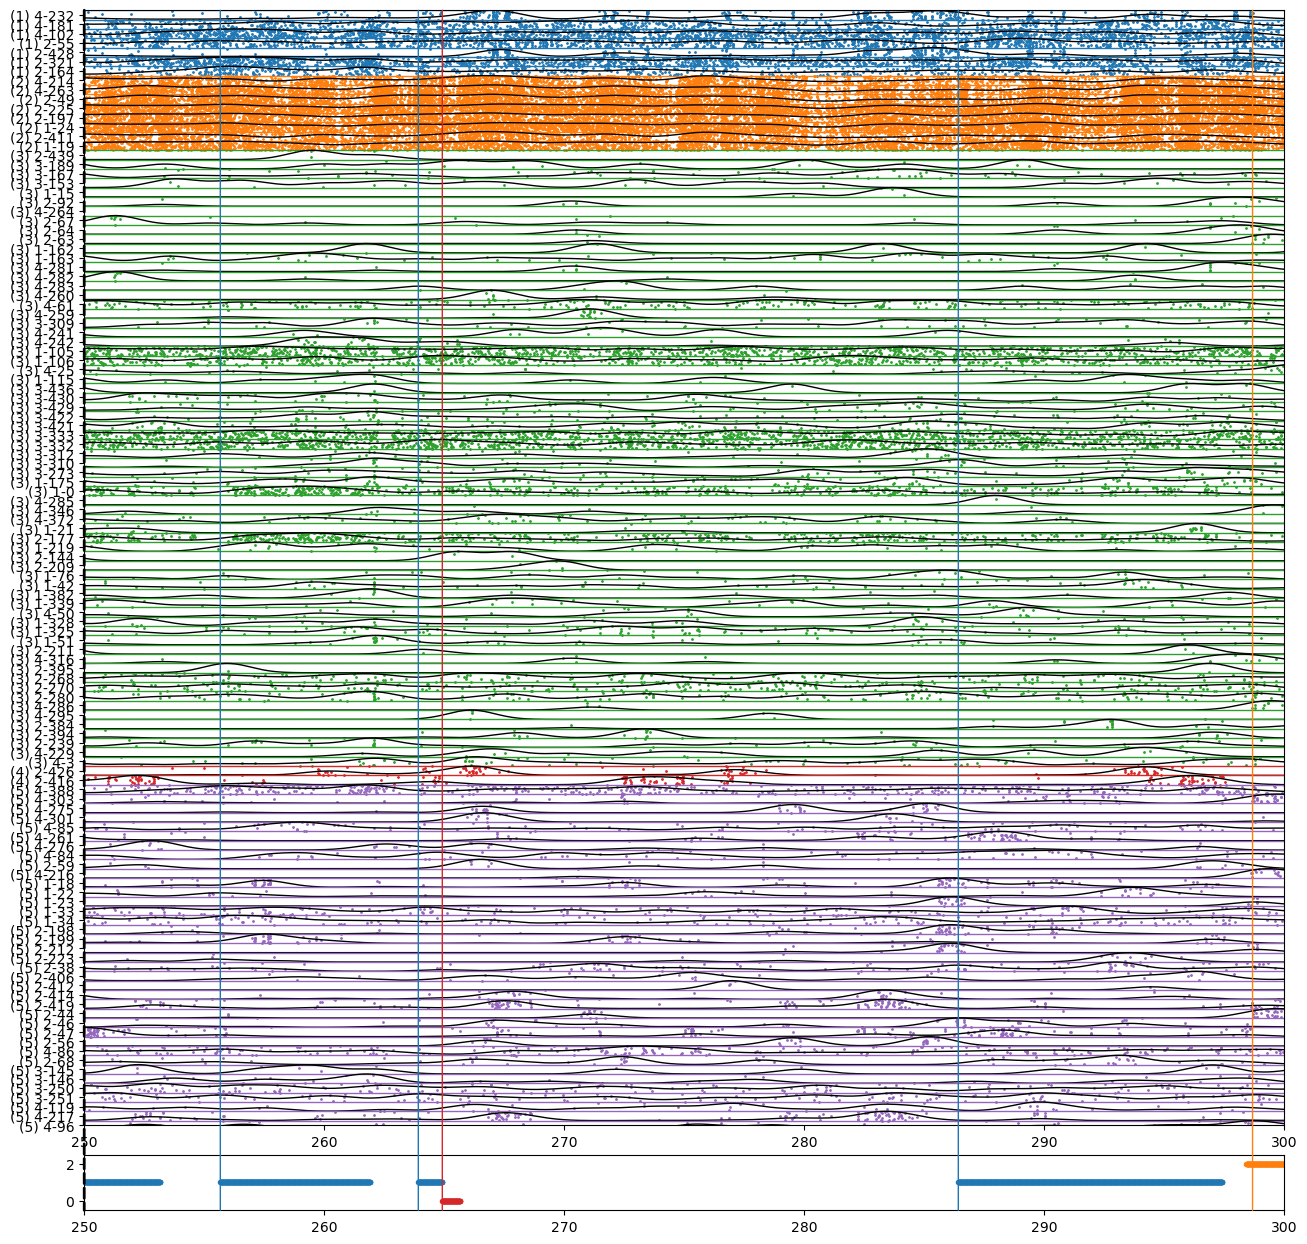

In [54]:
plt.show()

(50000.0, 150000.0)

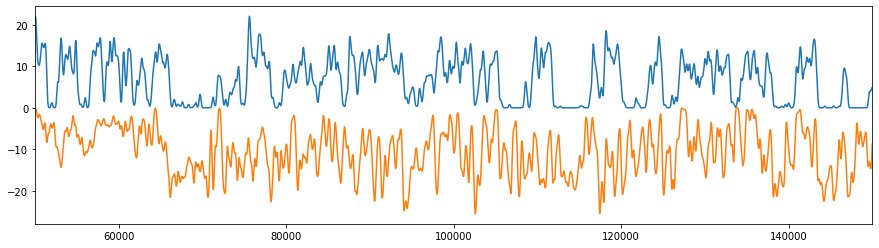

In [444]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(single_units['8-8'])
ax.plot(-single_units['7-16'])
#ax.plot(single_units['8-10'])
ax.set_xlim(50000, 150000)

In [210]:
# another version of animation with matplotlib
if False:
    # ----- time animation line
    # https://matplotlib.org/stable/gallery/animation/multiple_axes.html#sphx-glr-gallery-animation-multiple-axes-py
    # https://stackoverflow.com/questions/31252107/how-to-draw-vertical-lines-interactively-in-matplotlib
    anim_line = ConnectionPatch(xyA=[t_l, v_max], coordsA=ax1.transData, xyB=[t_l, v_min], \
                                coordsB=ax2.transData, color='black')
    anim_line.set(lw=2, ls='--')
    fig.add_artist(anim_line)
    
    def animate(t):
        anim_line.xy1 = (t, v_max)
        anim_line.xy2 = (t, v_min)
        #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        print('\rFrame at time %.2f rendered' % t, end='')
        return anim_line

    fps = 20
    ani = animation.FuncAnimation(fig, animate, interval=1000/fps, blit=False, \
                                      frames=np.linspace(t_l, t_r, (t_r - t_l)*fps), repeat_delay=100)

    ani_path = os.path.join(rep_path, '%s_%s_%s_1x.mp4' % (session[-19:-6], t_l, t_r))
    ani.save(ani_path, writer='ffmpeg', dpi=100, fps=20)  # extra_args=['-vcodec','libx264'], savefig_kwargs={ "bbox_inches": "tight" }

In [268]:
# import os, subprocess

# crop original video (right black part)
# ffmpeg -i video_labeled.mp4 -vf "crop=900:768:0:0" -c:a copy out.mp4

# # scale to match height
# ffmpeg -i out.mp4 -vf scale=-2:1242 outs.mp4

# cut in pieces of with overlap
# t_start  = t_l
# duration = t_r - t_l
# in_path  = os.path.join(rep_path, 'outs.mp4')
# out_path = os.path.join(rep_path, 'outs_%s_%s.mp4' % (t_l, t_r))

# cmd = 'ffmpeg -ss %s -i %s -c copy -t %s %s' % (t_start, in_path, duration, out_path)
# return_code = subprocess.call(cmd, shell=True)

In [269]:
# for each fragment:
# produce images (at desired resolution)
# compile images into a video with ffmpeg

# merge two videos side by side
# ffmpeg -i left.mp4 -i right.mp4 -filter_complex hstack output.mp4
#https://www.futurelearn.com/info/courses/introduction-to-image-analysis-for-plant-phenotyping/0/steps/305359

In [336]:
[x for x in np.arange(0, 2)]

[0, 1]

In [337]:
int(0.25/0.24)

1